In [44]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/Users/Raya/miniconda3/envs/rise_latest/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
              'scroll': True,
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'sky',
 'transition': 'zoom'}

In [46]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Spam Filtering for Short Messages
## Data Science CSCI 183
### Ryan Johnson, Grace Nguyen, and Raya Young
Spring 2017 <br>
Professor Manna

### Abstract
Spam messages are annoying! <br>
What if there was a way to stop getting annoying spam messages altogether, without losing any important messages? <br>
We have used Logistic Regression and Gradient Descent to automatically detect spam messages so you don't have to take time out of your busy day to delete it.

Input: A short text message or email notification <br>
Output: Our algorithm will classify this message as either spam or not spam (ham)

### Training Phase
Training Data: List of messages already classified as either spam or ham <br>
Used Gradient Descent to train the algorithm and create a decision boundary based on which words are more closely associated with spam or ham <br>

In [71]:
%matplotlib inline

# Basic
import io
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
import random

# SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve, auc

# NLTK
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Word Cloud
from wordcloud import WordCloud

In [48]:
data = pd.read_csv("training-data/spamcollectiondata.tsv", sep='\t', names = ["Category", "Message"])
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [49]:
spam = data.loc[data['Category'] == 'spam']
spam.head()

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [50]:
ham = data.loc[data['Category'] == 'ham']
ham.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


### Count the number of spam messages

In [32]:
# Count the number of spam messages
data.loc[data['Category']=='spam'].count()

Category    747
Message     747
dtype: int64

### Count the number of ham messages

In [33]:
# Count the number of non spam messages
data.loc[data['Category']=='ham'].count()

Category    4825
Message     4825
dtype: int64

In [35]:
# Converting to lower case
spam = [word.lower() for word in spam['Message']]
ham = [word.lower() for word in ham['Message']]

#### Stopword removal
Clean both sets of data by removing stopwords. This way, the word cloud will not be completely populated by common stop words. Stemming will not be done in generating word clouds, so we do not have a cloud composed of fragments of words.

Spam:

In [36]:
stop = set(stopwords.words('english'))
filtered = ""
clean_spam = ""
for message in spam:
    sentence = message.split(" ")
    for word in sentence:
        if word.lower() not in stop:
            filtered = filtered + " " + word
    clean_spam = clean_spam + " " + filtered
    filtered = ""

Ham:

In [37]:
clean_ham = ""
for message in ham:
    sentence = message.split(" ")
    for word in sentence:
        if word.lower() not in stop:
            filtered = filtered + " " + word
    clean_ham = clean_ham + " " + filtered
    filtered = ""

### Creating Spam Word Cloud

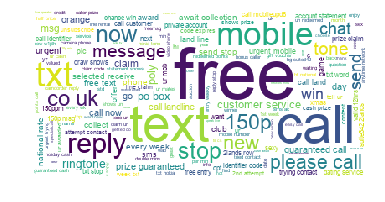

In [38]:
wordcloud = WordCloud(font_path='/Library/Fonts/Arial.ttf',
                      relative_scaling = 1.0,
                      background_color = "white",
                      ).generate(clean_spam)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<img src="visuals/training_spam.png">

### Creating Ham Word Cloud:

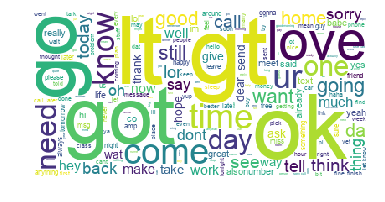

In [39]:
wordcloud = WordCloud(font_path='/Library/Fonts/Arial.ttf',
                      relative_scaling = 1.0,
                      background_color = "white",
                      ).generate(clean_ham)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<img src="visuals/training_ham.png">

## Comparing Frequency of capital letters

In [62]:
#hideme
ham_caps = []
spam_caps = []

for index,row in data.iterrows():
    if row.Category == 'ham':
        ham_caps.append(sum(1.0 for c in row.Message if c.isupper())/sum(1.0 for c in row.Message))
    else:
        spam_caps.append(sum(1.0 for c in row.Message if c.isupper())/sum(1.0 for c in row.Message))

        
ham_weight = np.ones_like(ham_caps)/len(ham_caps)
spam_weight = np.ones_like(spam_caps)/len(spam_caps)

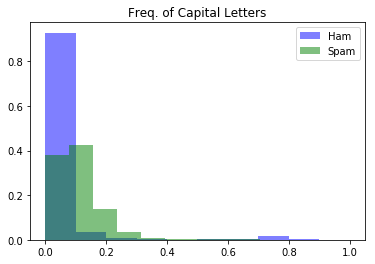

In [63]:
fig, ax = plt.subplots()
ax.hist(ham_caps,weights=ham_weight,color='b',alpha=0.5,label='Ham')
ax.hist(spam_caps,weights=spam_weight,color='g',alpha=0.5,label='Spam')
ax.set(title='Freq. of Capital Letters')
plt.legend()
plt.show()

<img src="visuals/cap_freq.png">

### Comparing frequency of numbers

In [60]:
ham_nums = []
spam_nums = []

for index,row in data.iterrows():
    if row.Category == 'ham':
        ham_nums.append(sum(1.0 for c in row.Message if c.isdigit())/sum(1.0 for c in row.Message))
    else:
        spam_nums.append(sum(1.0 for c in row.Message if c.isdigit())/sum(1.0 for c in row.Message))

        
ham_weight = np.ones_like(ham_nums)/len(ham_nums)
spam_weight = np.ones_like(spam_nums)/len(spam_nums)

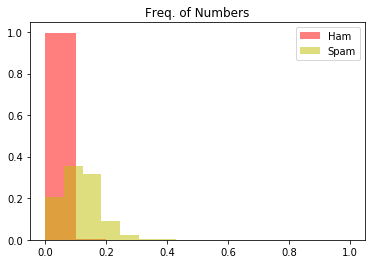

In [61]:
fig, ax = plt.subplots()
ax.hist(ham_nums,weights=ham_weight,color='r',alpha=0.5,label='Ham')
ax.hist(spam_nums,weights=spam_weight,color='y',alpha=0.5,label='Spam')
ax.set(title='Freq. of Numbers')
plt.legend()
plt.show()

<img src="visuals/num_freq.png">

### Finding Accuracy

In [57]:
inpf1 = pd.read_csv("log_reg_output.csv")
inpf1.head()

,Unnamed: 0,Actual,Predicted,Prob is Ham,Prob is Spam
0,0,0,0,0.865463,0.134537
1,1,0,0,0.898919,0.101081
2,2,1,0,0.860582,0.139418
3,3,0,0,0.859309,0.140691
4,4,0,0,0.876628,0.123372


Final Accuracy: 86.2%

In [53]:
actual = inpf1['Actual'].tolist()
predictions = inpf1['Predicted'].tolist()

In [54]:
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

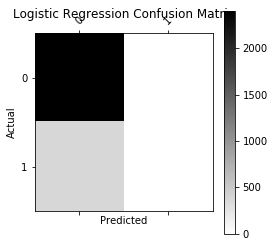

In [64]:
def plot_confusion_matrix(df_confusion, title='Logistic Regression Confusion Matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()

plot_confusion_matrix(df_confusion)

<img src="visuals/log_reg.jpeg">

# Demo

In [72]:
message_data = [word.lower() for word in data['Message']]
category = data['Category'].tolist()
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
training_set = []
i = 0
for message in message_data:
    sentence = message.split(" ")
    filtered = []
    pr = []
    for word in sentence:
        if word.lower() not in stop:
            stemmed = stemmer.stem(word)
            filtered.append(stemmed)
    pr.append(filtered)
    pr.append(category[i])
    training_set.append(pr)
    i = i+1
    
train_df = pd.DataFrame(training_set)
train_df.columns = ['Lists','Labels']
train_df.head()
y = np.array(train_df.Labels)

for i in range(len(y)):
    if y[i] == 'ham':
        y[i] = 1
    else:
        y[i] = 0
        
y = np.ravel(y)

In [73]:
def list_to_dict(words_list):
  return dict([(word, True) for word in words_list])
 
training_set_formatted = [(list_to_dict(element[0]), element[1]) for element in training_set]

def generate_words_vector(training_set):
    words_vector = [] 
    for review in training_set:
        for word in review[0]:
            if word not in words_vector: words_vector.append(word) 
    return words_vector

def generate_X_matrix(training_set, words_vector):
    no_reviews = len(training_set)
    no_words = len(words_vector)
    X = np.zeros(shape=(no_reviews, no_words+1))
    for ii in range(0,no_reviews):
        X[ii][0] = 1
        review_text = training_set[ii][0]
        total_words_in_review = len(review_text)
        rt = list(review_text)
        for word in rt:
            word_occurences = rt.count(word)
            word_index = words_vector.index(word)+1
            X[ii][word_index] = word_occurences / float(total_words_in_review)
    return X

words_vector = generate_words_vector(training_set_formatted)
X = np.array(generate_X_matrix(training_set_formatted, words_vector))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df.Labels, test_size=0.5, random_state=1)
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
test_phrase_1 = "lt gt go come ok love"
test_phrase_2 = "call free mobil co.uk"

In [78]:
arr_1 = np.zeros(len(X[0]))
arr_2 = np.zeros(len(X[0]))

for ii in range(len(test_phrase_1.split())):
    review_text = test_phrase_1.split()
    total_words_in_review = len(review_text)
    rt = list(review_text)
    for word in rt:
        word_occurences = rt.count(word)
        if word in words_vector:
            word_index = words_vector.index(word)+1
            arr_1[word_index] = word_occurences / float(total_words_in_review)

for ii in range(len(test_phrase_2.split())):
    review_text = test_phrase_2.split()
    total_words_in_review = len(review_text)
    rt = list(review_text)
    for word in rt:
        word_occurences = rt.count(word)
        if word in words_vector:
            word_index = words_vector.index(word)+1
            arr_2[word_index] = word_occurences / float(total_words_in_review)
            
arr_1[0] = 1
arr_2[0] = 1

pct_1 = model.predict_proba(arr_1.reshape(1,-1))[0][0]*100
pct_2 = model.predict_proba(arr_2.reshape(1,-1))[0][0]*100

###########################

result_1 = result_2 = 'SPAM'

if(pct_1>50):
    result_1 = 'HAM'
if(pct_2>50):
    result_2 = 'HAM'

In [79]:
print("\"{}\" --> {} \n\t{}% Ham / {}% Spam.".format(test_phrase_1,result_1,round(pct_1,1),round(100-pct_1,1)),"\n")
print("\"{}\" --> {} \n\t{}% Ham / {}% Spam.".format(test_phrase_2,result_2,round(pct_2,1),round(100-pct_2,1)))

"lt gt go come ok love" --> HAM 
	93.2% Ham / 6.8% Spam. 

"call free mobil co.uk" --> SPAM 
	45.6% Ham / 54.4% Spam.


## Comparative Algorithm: Naive Bayes
Used NLTK version of the algorithm <br>
Much slower than Logistic Regression <br>
Lower accuracy than Logistic <br>
Accuracy: 76.6%

<img src="visuals/naivebayes.jpeg">